# Лабораторная работа №1: Метрические методы


# Постановка задачи:

1. Применить метод K ближайших соседей.

3. Применить взвешенный метод K ближайших соседей (окно Парзена).

4. Применить метод K ближайших соседей для датасета из векторизованных с помощью эмбеддинга картинок. Полученный результат применить к своим фотографиям.

# Подключение зависимостей

In [1]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 35.7 MB/s eta 0:00:00


In [52]:
import mediapipe as mp
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm

from scipy.special import softmax
from scipy.spatial.distance import cdist
import numpy as np
import torch

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from mlxtend.plotting import plot_decision_regions
from torchvision import datasets, transforms
import torch

import os


# Вспомогтельные функции

In [50]:
def show_samples(X_test, predictions):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    for idx in range(len(X_test)):
        point = X_test[idx]
        ax.scatter(point[0], point[1], point[2], c = f"C{predictions[idx]}")

    plt.show()

# Генерация набора данных

In [4]:
X, Y = make_classification(n_samples=500, n_features=3,
                           n_informative=3, n_classes=5,
                           n_redundant=0,
                           n_clusters_per_class=1,
                           random_state=6)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=100, random_state=0)

# KNN

In [5]:
min_n_neighbors = 3
max_n_neighbors = 8

In [6]:
models = []
for n_neighbors in range(min_n_neighbors, max_n_neighbors):
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train, Y_train)
    models.append(model)

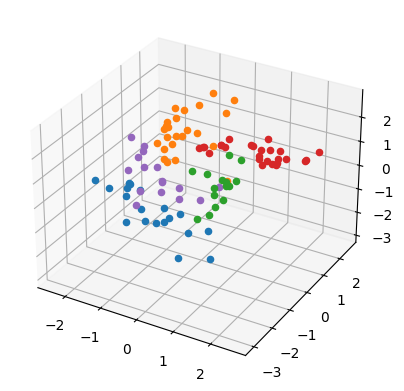

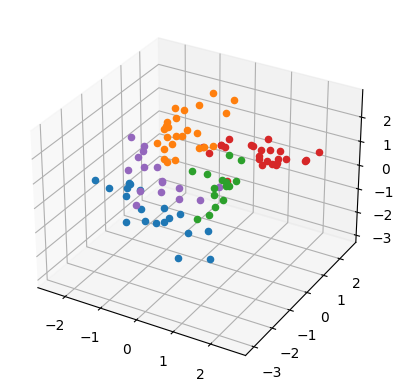

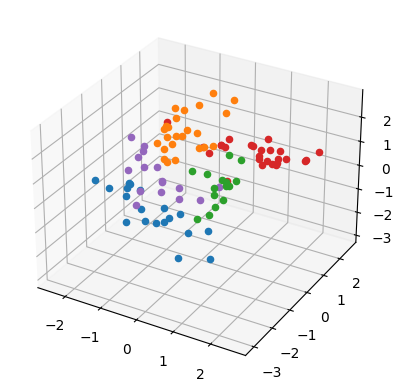

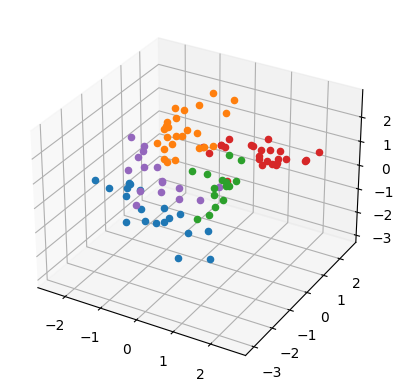

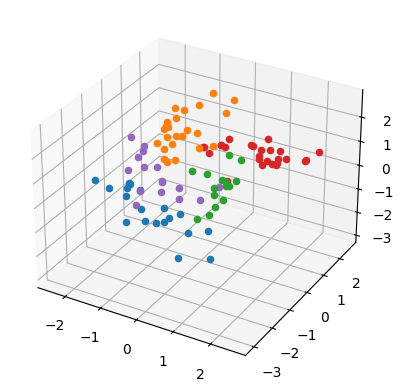

In [51]:
for i in range(max_n_neighbors - min_n_neighbors):
    predictions = models[i].predict(X_test)
    show_samples(X_test, predictions)

# KNN (взвешенный способ: окно Парзена)

In [8]:
min_n_neighbors = 3
max_n_neighbors = 8

In [9]:
def K(distance, h=0.3):
    ret = np.array(distance)/h
    return (1 - ret**2) * (np.abs(ret) <= 1)

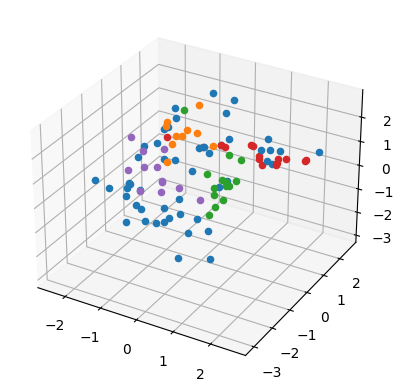

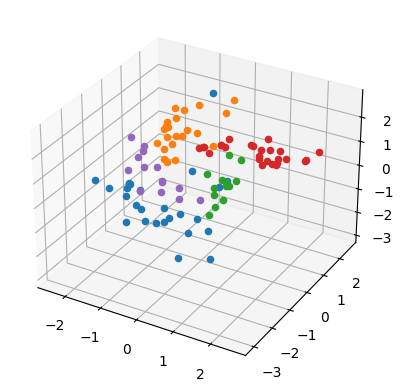

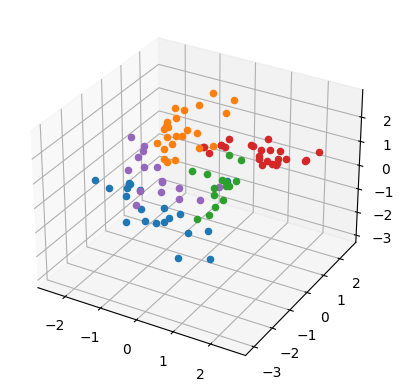

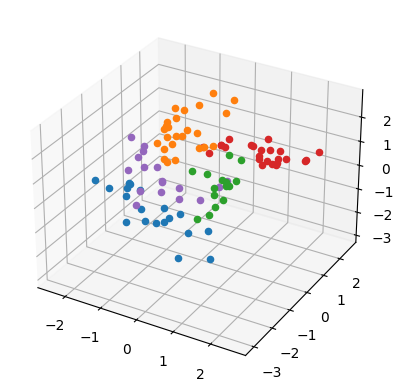

In [47]:
for i, h in enumerate([0.3, 0.5, 0.7, 0.9]):
    model = KNeighborsClassifier(n_neighbors=len(X_train), weights=lambda x: K(x, h=h))
    model.fit(X_train, Y_train)
    predictions = model.predict(X_test)
    show_samples(X_test, predictions)

# KNN для векторизованных картинок

[Facial expressions dataset](https://www.kaggle.com/datasets/msambare/fer2013)

The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The training set consists of 28,709 examples and the public test set consists of 3,589 examples.

Загрузка датасета


In [16]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/MyDrive/'archive.zip'

In [69]:
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

Эмбеддинг

In [20]:
BaseOptions = mp.tasks.BaseOptions
ImageEmbedder = mp.tasks.vision.ImageEmbedder
ImageEmbedderOptions = mp.tasks.vision.ImageEmbedderOptions
VisionRunningMode = mp.tasks.vision.RunningMode

options = ImageEmbedderOptions(
    base_options=BaseOptions(model_asset_path='gdrive/MyDrive/mobilenet_v3_small_075_224_embedder.tflite'),
    quantize=True,
    running_mode=VisionRunningMode.IMAGE)

In [21]:
with ImageEmbedder.create_from_options(options) as embedder:
    image_embeddings = []
    image_labels = []
    for cl in range(len(classes)):
        for im_file in os.listdir('./train/' + classes[cl]):
            if im_file.endswith('jpg'):
                mp_image = mp.Image.create_from_file('./train/' + classes[cl] + '/' + im_file)
                embedding_result = embedder.embed(mp_image)
                image_embeddings.append(embedding_result.embeddings[0].embedding)
                image_labels.append(cl)

Применение KNN

In [62]:
model = KNeighborsClassifier(n_neighbors=3)

In [63]:
model.fit(np.array(image_embeddings), np.array(image_labels))


KNeighborsClassifier(n_neighbors=3)

Оценка полученных результатов

In [64]:
from sklearn.metrics import accuracy_score

preds = model.predict(np.array(image_embeddings))
accuracy_score(np.array(image_labels), preds)

0.6538019436413668

Применение KNN к собственным фото

In [65]:
import cv2

In [67]:
with ImageEmbedder.create_from_options(options) as embedder:
    mp_image = mp.Image.create_from_file('gdrive/MyDrive/ya.png')
    embedding_result = embedder.embed(mp_image).embeddings[0].embedding

In [68]:
print(classes[model.predict(np.array(embedding_result).reshape(1, -1))[0]])

angry


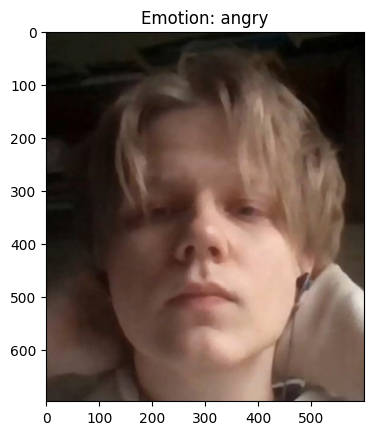

In [75]:
fig, ax = plt.subplots()
ax.set_title("Emotion: " + classes[model.predict(np.array(embedding_result).reshape(1, -1))[0]])
ax.imshow(cv2.cvtColor(cv2.imread('gdrive/MyDrive/ya.png'), cv2.COLOR_BGR2RGB))